![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Aprendizaje Automático

# Practica 02

# Redes Neuronales Problemas Multiclase y Optimización (fine tunning)

### Autor: Diego Tapia


## 1. Descripción del dataset



**Nombre del Dataset:** CIFAR10

**Descripción del dataset CIFAR10**

CIFAR-10 es un conjunto de datos utilizado para el reconocimiento de objetos en imágenes. Es uno de los conjuntos de datos más ampliamente utilizados por investigadores, ingenieros, practicantes y aficionados a la visión computarizada y machine learning. CIFAR son las siglas del Canadian Institute for Advanced Research (Jesús, 2020).




**Dimensiones:** CIFAR contiene 60000 imágenes

Cada imagen es de 32x32pixeles y tienen 3 canales (RGB).

Hay 50000 imágenes de entrenamiento y 10000 para testing.

Hay 10 categorías, donde cada una está representada por 6000 imágenes.

    airplane : 0

    automobile : 1

    bird : 2

    cat : 3

    deer : 4

    dog : 5

    frog : 6

    horse : 7

    ship : 8

    truck : 9


URL: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"



## 2. Análisis Exploratorio del dataset



### Carga del dataset desde archivo local

In [1]:

# Se descomprime el archivo cargado en Google Drive
!tar xzvf ./dataset/cifar-10-python.tar.gz


x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [2]:
# instalación e importación de librerías
#%pip install six
#%pip install scikeras

import tarfile
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
#from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config

In [3]:

import numpy as np
import matplotlib.pyplot as plt


import pickle

# Función para indicar el nombre de las categorías
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Función para cargar cada batch de imágenes
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    #cada batch 10000 imágenes, cada imagen de 32x32x3
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

# Función para visualizar una imagen de un batch específico del dataset y presentar sus caracerísticas más relevantes
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nEstadísticas del batch {}:'.format(batch_id))
    print('Samples (cantidad de imágenes): {}'.format(len(features)))
    print('Cantidad de Etiquetas: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('Primeras 20 Etiquetas: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nImagen #{}:'.format(sample_id))
    print('Imagen - Valor Min: {} Valor Max: {}'.format(sample_image.min(), sample_image.max()))
    print('Imagen - Dimensiones: {}'.format(sample_image.shape))
    print('Etiqueta - Etiqueta Id: {} Nombre: {}'.format(sample_label, label_names[sample_label]))
    #plt.axis('off')
    plt.title("Figura 1: Imagen de muestra del Dataset")
    plt.imshow(sample_image)



### Exploracion del dataset

Se muestra una de las imágenes del dataset, del lote 1 (Categoría: dog) y sus características


Estadísticas del batch 4:
Samples (cantidad de imágenes): 10000
Cantidad de Etiquetas: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Primeras 20 Etiquetas: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Imagen #3000:
Imagen - Valor Min: 21 Valor Max: 248
Imagen - Dimensiones: (32, 32, 3)
Etiqueta - Etiqueta Id: 0 Nombre: airplane


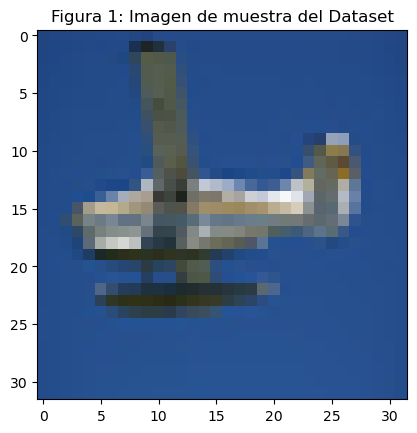

In [4]:
batch_id = 4
sample_id = 3000
cifar10_dataset_folder_path='cifar-10-batches-py'
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

Como se puede observar en la Figura 1, las dimensiones son 32x32 con 3 canales, para usar estas imagenes en una red neuronal, debemos tranformar esa dimensión a un solo valor.

## Carga del dataset desde libreria

Se puede cargar el dataset completo desde una la libreria de Keras.datasets usando el metodo:

 ```cifar10.load_data()```


El dataset se carga directamente, en los conjuntos de Training (50000) y Testing (10000): X_train, X_test, y_train, y_test

In [5]:
from tensorflow.keras.datasets import cifar10
cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


### Análisis de frecuencia de categorías

Aunque ya se conoce que se tienen 10 categorías con 6000 imágenes cada una,
a partir de los conjuntos de entrenamiento y testing, podemos realizar un análisis de frecuencias de las categorías del dataset.

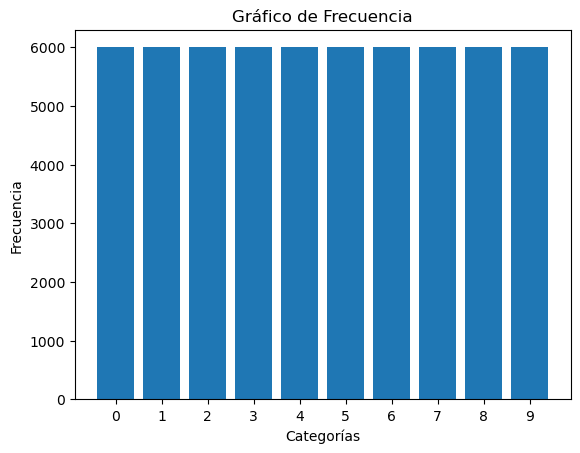

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
Y=y_train.flatten().tolist()
Y.extend(y_test.flatten().tolist())

# Utiliza Counter para contar las frecuencias de los elementos en la lista
frecuencias = Counter(Y)

# Separa las claves (elementos) y los valores (frecuencias) en listas separadas
elementos = list(frecuencias.keys())
frecuencias = list(frecuencias.values())

# Crea un gráfico de barras
plt.bar(elementos, frecuencias)

# Etiquetas y título
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencia')

# Establece las etiquetas del eje X
plt.xticks(elementos)

# Muestra el gráfico
plt.show()

## 3. Desarrollo, entrenamiento y optimización (fine tunning) de una Red Neuronal para clasificación multiclase usando el dataset CIFAR10

### Desarrollo y entrenamiento de Modelo Base de la Red Neuronal

#### Normalización


In [7]:
# Normalizamos tanto X_train como X_test, en este caso de forma sencilla porque los valores de los pixeles van de 0 a 255.
x_train = X_train/255
x_test = X_test/255
print("Normalización lista!")

#Ejemplo para verificar
print('x:',X_test[9999,1,1,1])
print("""x':""",x_test[9999,1,1,1])

Normalización lista!
x: 89
x': 0.34901960784313724


#### Transformación

Cada imagen es de 32x32pixeles y tiene 3 canales. Cada fila (imagen) de CIFAR10 es de 3072 columnas. 32pixeles x 32pixeles x 3canales = 3072 características

In [8]:
#Para transformar X en estructura clásica de ML (2D) para aplicar técnicas como SVM, Redes Neuronales Densas, KNN, etc.
X_trainReshapeImageRow=x_train.reshape((x_train.shape[0],3072))
print(X_trainReshapeImageRow.shape)
X_testReshapeImageRow=x_test.reshape((x_test.shape[0],3072))
print(X_testReshapeImageRow.shape)

(50000, 3072)
(10000, 3072)


#### Descripción de una imagen transformada para usar en un modelo de Red Neuronal


Imagen 3000:
Imagen - Valor Min: 0.1411764705882353 Valor Max: 1.0
Imagen - Shape: (3072,)
Etiqueta - Etiqueta Id: 3 Nombre: cat


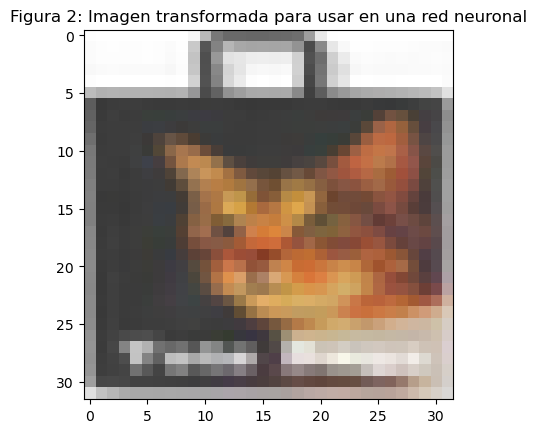

In [9]:
# Función para visualizar y describir una imagen específica

def display_stats_2(sample_id):
    features, labels = X_trainReshapeImageRow, y_train
    sample_image = features[sample_id]
    sample_label = labels[sample_id][0]
    label_names = _load_label_names()
    print('\nImagen {}:'.format(sample_id))
    print('Imagen - Valor Min: {} Valor Max: {}'.format(sample_image.min(), sample_image.max()))
    print('Imagen - Shape: {}'.format(sample_image.shape))
    print('Etiqueta - Etiqueta Id: {} Nombre: {}'.format(sample_label, label_names[sample_label]))
    #plt.axis('off')
    imagen=sample_image.reshape(32, 32, 3)#.transpose(1, 2, 0)
    plt.title("Figura 2: Imagen transformada para usar en una red neuronal")
    plt.imshow(imagen)
    #cv.imwrite('imagen.jpg', imagen)
sample_id = 3000
display_stats_2(sample_id)

En la imagen de la figura 2, en su descripción podemos ver que la dimensión (shape), es ahora solo un valor, 3072 que corresponde al número de características (columnas) de cada imagen (fila)

#### Modelo base de la Red Neuronal

In [16]:
from sklearn.pipeline import Pipeline

# Se define el modelo base
def create_model():


  model = Sequential([
      Dense(32, input_dim=X_trainReshapeImageRow.shape[1], activation='relu'),
      Dense(10, activation='softmax')
  ])
  #compilamos el modelo
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model


modelo_base = create_model()



print("modelo base creado")

pipe = Pipeline(
    steps=[]
)
pipe.steps.append(['modelNN', modelo_base])
print("Cantidad de pasos: ",len(pipe.steps))

#Mostrar el resumen de la arquitectura de la red neuronal.
pipe.named_steps['modelNN'].summary()

modelo base creado
Cantidad de pasos:  1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                98336     
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 98666 (385.41 KB)
Trainable params: 98666 (385.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento modelo base

Se realiza el entrenamiento del modelo base, con un batch_size de 32 y el numero de epocas en 10

In [17]:

size_batch = 32
epocas = 10
pipe.fit(X_trainReshapeImageRow, y_train, modelNN__batch_size= size_batch, modelNN__epochs=epocas, modelNN__verbose=1)



Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 2.0776 - accuracy: 0.2206
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9730 - accuracy: 0.2447
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9476 - accuracy: 0.2478
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9403 - accuracy: 0.2488
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9316 - accuracy: 0.2518
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9261 - accuracy: 0.2526
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9239 - accuracy: 0.2555
Epoch 8/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.9171 - accuracy: 0.2579
Epoch 9/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.8834 - accuracy: 0.2845
Epoch 10/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.863

Pipeline(steps=[['modelNN',
                 <keras.src.engine.sequential.Sequential object at 0x0000028470E61890>]])

### Evaluación del modelo base

In [18]:
#Predicciones con el conjunto de Test
import pandas as pd
#y_pred = modelo_base.predict(X_testReshapeImageRow)
y_pred = pipe.predict(X_testReshapeImageRow)

print("y_pred antes del aplanado")
y_pred_df = pd.DataFrame(y_pred, columns=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
print(y_pred_df.tail(3))
#argmax identifica el valor máximo para determinar la categoría
y_pred = np.argmax(y_pred, axis=-1)

y_pred = y_pred.flatten()
y_test_f = y_test.flatten()

dataframeFinal=pd.DataFrame({'real':y_test_f, 'predicción': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

313/313 [==============================] - 1s 2ms/step
y_pred antes del aplanado
      airplane  automobile      bird       cat      deer       dog      frog  \
9997  0.023149    0.033520  0.090868  0.232433  0.085513  0.308363  0.144343   
9998  0.041535    0.101040  0.109340  0.149007  0.112978  0.121659  0.123600   
9999  0.098847    0.023325  0.223102  0.072348  0.184878  0.065796  0.047005   

         horse      ship     truck  
9997  0.043170  0.023824  0.014816  
9998  0.117049  0.041955  0.081837  
9999  0.202408  0.043288  0.039004  


,real,predicción
0,3,5
1,8,9
2,8,8
3,0,0
4,6,4
5,6,6
6,1,5
7,6,6
8,3,2
9,1,9


Accuracy  Precision  Recall  F1-score
0.2916    0.2916    0.2916    0.2916


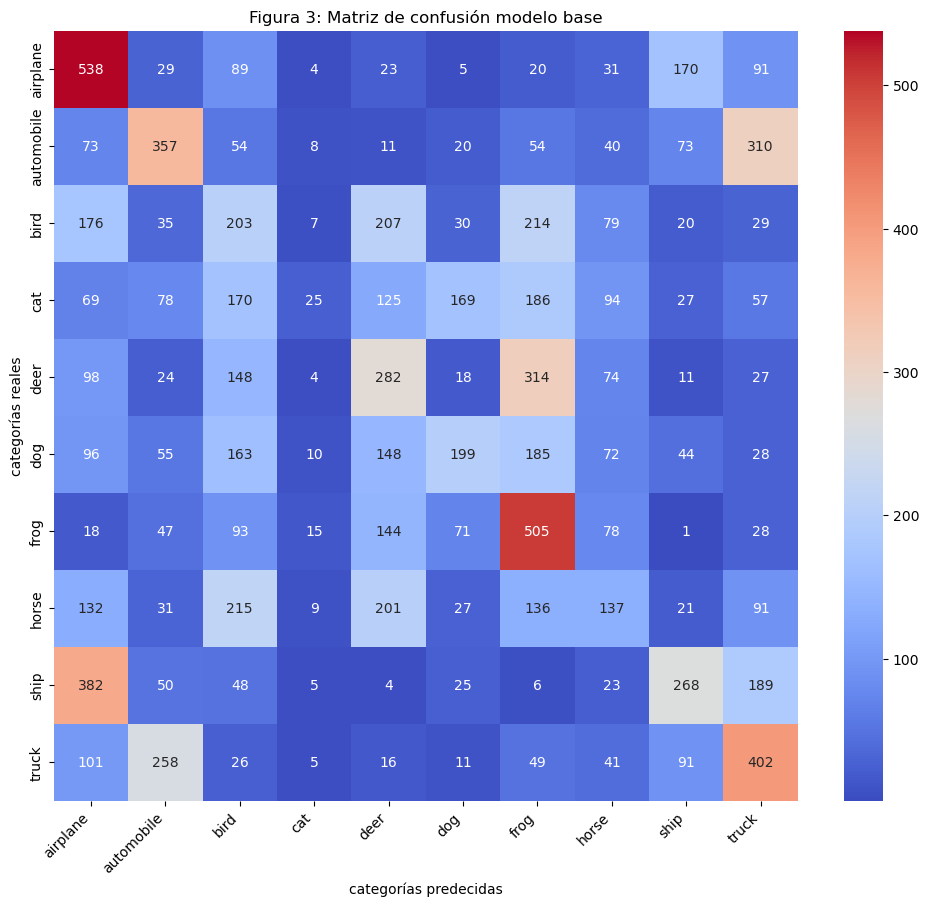

In [19]:
# Calcular metricas de evaluacion
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluar_modelo(y_test, y_pred):
  # Calcular la matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Calcular las métricas de evaluación a partir de la matriz de confusión
  tp = np.diag(conf_matrix)
  fp = np.sum(conf_matrix, axis=0) - tp
  fn = np.sum(conf_matrix, axis=1) - tp

  accuracy = np.mean(tp / (tp + fn))
  precision = np.mean(tp / (tp + fp))
  recall = np.mean(tp / (tp + fn))
  f1 = 2 * precision * recall / (precision + recall)

  # Imprimir resultados
  print("Accuracy  Precision  Recall  F1-score")
  print(f"{accuracy:.4f}    {precision:.4f}    {recall:.4f}    {f1:.4f}")

  # Crear el plot de la matriz de confusión
  plt.figure(figsize=(12, 10))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')

  # Añadir etiquetas y título
  plt.xlabel('categorías predecidas')
  plt.ylabel('categorías reales')
  plt.xticks(np.arange(conf_matrix.shape[0])+0.5, labels=_load_label_names(),rotation=45, ha="right")
  plt.yticks(np.arange(conf_matrix.shape[1])+0.5, labels=_load_label_names())
  plt.title('Figura 3: Matriz de confusión modelo base')

  # Mostrar el plot
  plt.show()

evaluar_modelo(y_test, y_pred)




En la figura 3 podemos observar que la categoria con mas imagenes clasificadas correctamente por el modelo base de red neuronal es "barco" (ship) con 522 verdaderos positivos. Tambien podemos observar un **accuracy de 0.32**

### Entrenamiento y evaluación del modelo base usando K-fold


Se divide el conjunto de testing en 5 "folds" para aplicar la "validación cruzada"

In [40]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from scikeras.wrappers import KerasClassifier
#from scikeras.wrappers import KerasTransformer

#kfold es la configuración de validación K-Fold Cross-Validation
numFolds=5
kfold = ShuffleSplit(n_splits=numFolds)
# Crear un wrapper KerasTransformer para tu modelo de Keras
estimator = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

pipe.steps.pop()
pipe.steps.append(['modelNN', estimator])

# Se carga en Y la variables de salida del dataset
# Concatenar las etiquetas de entrenamiento y prueba en una sola variable "Y"
Y = np.concatenate((y_train, y_test), axis=0)
# Se carga en Xt los conjuntos de entrenamiento y testing convertidos
Xt = np.concatenate((X_trainReshapeImageRow, X_testReshapeImageRow), axis=0)
# Se aplica kfolding en el modelo base
#n_jobs es para ocupar mas de un procesador. El parámetro -1 indica que se utilizarán todos los procesadores disponibles
cvs=cross_val_score(pipe, X_trainReshapeImageRow, y_train, cv=5, n_jobs=2 )

print("Scores:")# accuracy
for i in range(numFolds):
    print(cvs[i])
print("Accuracy de Modelo Base: ", cvs.mean())
accuracyModeloBase = cvs.mean()



Scores:
0.1855
0.3249
0.3583
0.1943
0.3579
Accuracy de Modelo Base:  0.28418


Se evalua el modelo entrenado con


Para la optimizacion se usa el GRID search (N entrenamientos)

### Optimización – Paso 1. Parámetros de compilación

In [ ]:
#Función para convertir el tiempo de segundos al formato de días, horas, minutos y segundos.
def GetTime(gs_time):
    sec=timedelta(seconds=gs_time)
    d = datetime(1,1,1) + sec
    tiempoTotal=("%d días: %d horas: %d min: %d seg" % (d.day-1, d.hour, d.minute, d.second))
    return tiempoTotal

## Referencias

Jesús. (2020, July 1). ¿Qué es CIFAR-10? DataSmarts Español. https://datasmarts.net/es/que-es-cifar-10/